In [1]:
%matplotlib inline
import numpy as np
import power_laws
from scipy.stats import linregress, pearsonr
from scipy.stats import gmean
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib import gridspec
import rubisco_data

import matplotlib.colors
import seaborn as sns
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
savir_F1 = savir_df[savir_df.isoform == '1']

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

380 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


Total data points: 212
Savir data points: 18
Log-scale Covariance Matrix: C = 
         S     vC
S   0.009 -0.009
vC -0.009  0.031
trace(C) = 0.04

Eigenvalues of C (decreasing order):  [0.034 0.006]
sum(S) = 0.04
% variance explained = 85.7
Pearson R = -0.561, P = 5.54e-19


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


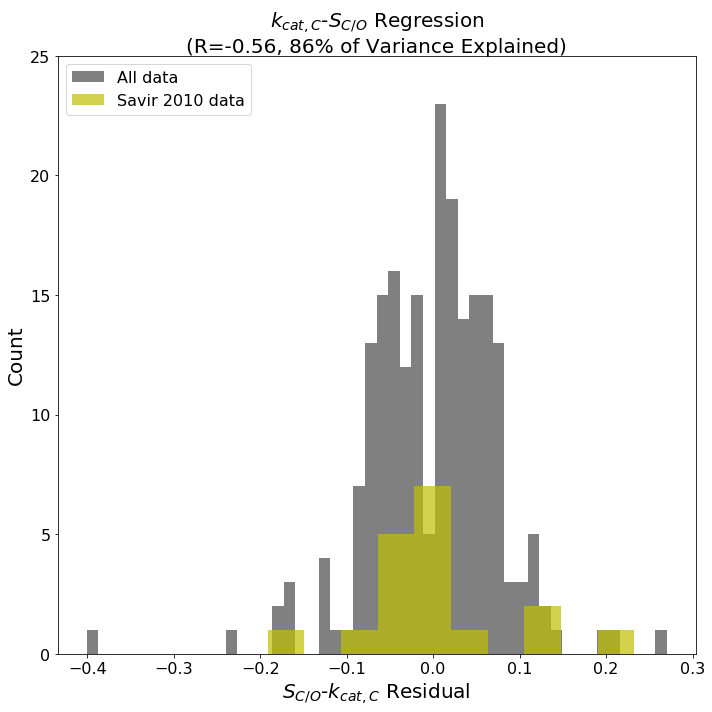

In [4]:
# 2D TLS regression of these variables
vars2use = ['S', 'vC']
v1, v2 = vars2use
xvar_name = '$S_{C/O}$'
yvar_name = '$k_{cat,C}$'
xlabel = '%s-%s Residual' % (xvar_name, yvar_name)

# Log10 transform, drop NaN, center on 0.0 for both vars
X_lin = F1_data[vars2use]
X_log = np.log10(X_lin).dropna()
X_log_zeromean = (X_log-X_log.mean(axis=0))
N = X_log_zeromean.shape[0]
print('Total data points:', N)

# Same for Savir et al 2010 data
savir_lin = savir_F1[vars2use]
savir_log = np.log10(savir_lin).dropna()
savir_log_zeromean = (savir_log-savir_log.mean(axis=0))
print('Savir data points:', savir_log.shape[0])

# Covariance matrix calc, SVD
C = (X_log_zeromean.T @ X_log_zeromean)/N
print('Log-scale Covariance Matrix: C = \n', C.round(3))
print('trace(C) = %.3g' % np.trace(C))
U, S, _ = svd(C)

# Singular vals are eigenvalues b/c C is a square symmetric matrix
print('\nEigenvalues of C (decreasing order): ', S.round(3))
print('sum(S) = %.3g' % sum(S))
# This value is % of variance explained usually quoted in PCA.
# More appropriate for TLS regression since it is not specific to Y err.
pct_var = (S[0]/sum(S))*100
pearson_r, pearson_p = pearsonr(X_log[v1], X_log[v2])
print('%% variance explained = %.3g' % pct_var)
print('Pearson R = %.3g, P = %.3g' % (pearson_r, pearson_p))

# U is a rotation matrix that neutralizes the off-diagonal correlations.
# Applying this rotation is the same as TLS because it treats X and Y error equally. 
# We calculate residuals as the distance to the Y axis after applying the rotation.
# This is the same as calculating the euclidean distance to the line pre-rotation. 
X_rot = (X_log_zeromean @ U).as_matrix()
savir_rot = (savir_log_zeromean @ U).as_matrix()

sns.color_palette('Set2')

figure = plt.figure(figsize=(10,10))
plt.hist(X_rot[:,1], bins=50, color='0.5',
         label='All data')
plt.hist(savir_rot[:,1], bins=10, color='y', alpha=0.7,
         label='Savir 2010 data')

plt.xlabel(xlabel, fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 25)

plt.legend(loc=2, fontsize=16)
title = '%s-%s Regression\n(R=%.2g, %.0f%% of Variance Explained)' % (
    yvar_name, xvar_name, pearson_r, pct_var)
plt.title(title, fontsize=20)
plt.tight_layout()

plt.savefig('figs12/figs12_kcatc_vs_s.png', dpi=600)

plt.show()

Total data points: 239
Savir data points: 18
Log-scale Covariance Matrix: C = 
        KC     vC
KC  0.078  0.022
vC  0.022  0.028
trace(C) = 0.106

Eigenvalues of C (decreasing order):  [0.086 0.02 ]
sum(S) = 0.106
% variance explained = 81.5
Pearson R = 0.48, P = 3.37e-15


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


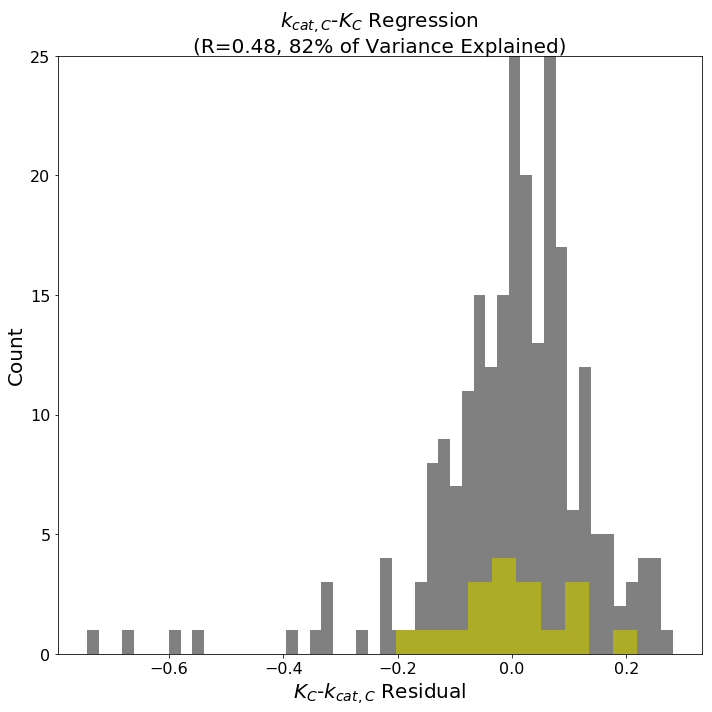

In [5]:
# 2D TLS regression of these variables
vars2use = ['KC', 'vC']
v1, v2 = vars2use
xvar_name = '$K_C$'
yvar_name = '$k_{cat,C}$'
xlabel = '%s-%s Residual' % (xvar_name, yvar_name)

# Log10 transform, drop NaN, center on 0.0 for both vars
X_lin = F1_data[vars2use]
X_log = np.log10(X_lin).dropna()
X_log_zeromean = (X_log-X_log.mean(axis=0))
N = X_log_zeromean.shape[0]
print('Total data points:', N)

# Same for Savir et al 2010 data
savir_lin = savir_F1[vars2use]
savir_log = np.log10(savir_lin).dropna()
savir_log_zeromean = (savir_log-savir_log.mean(axis=0))
print('Savir data points:', savir_log.shape[0])

# Covariance matrix calc, SVD
C = (X_log_zeromean.T @ X_log_zeromean)/N
print('Log-scale Covariance Matrix: C = \n', C.round(3))
print('trace(C) = %.3g' % np.trace(C))
U, S, _ = svd(C)

# Singular vals are eigenvalues b/c C is a square symmetric matrix
print('\nEigenvalues of C (decreasing order): ', S.round(3))
print('sum(S) = %.3g' % sum(S))
pct_var = (S[0]/sum(S))*100
pearson_r, pearson_p = pearsonr(X_log[v1], X_log[v2])
print('%% variance explained = %.3g' % pct_var)
print('Pearson R = %.3g, P = %.3g' % (pearson_r, pearson_p))

# Rotate to covariance 0
X_rot = (X_log_zeromean @ U).as_matrix()
savir_rot = (savir_log_zeromean @ U).as_matrix()

sns.color_palette('Set2')

figure = plt.figure(figsize=(10,10))
plt.hist(X_rot[:,1], bins=50, color='0.5',
         label='All data')
plt.hist(savir_rot[:,1], bins=10, color='y', alpha=0.7,
         label='Savir 2010 data')

plt.xlabel(xlabel, fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 25)

title = '%s-%s Regression\n(R=%.2g, %.0f%% of Variance Explained)' % (
    yvar_name, xvar_name, pearson_r, pct_var)
plt.title(title, fontsize=20)
plt.tight_layout()

plt.savefig('figs12/figs12_kcats_vs_kc.png', dpi=600)

plt.show()

Total data points: 239
Savir data points: 18
Log-scale Covariance Matrix: C = 
           vC  kon_C
vC     0.028  0.005
kon_C  0.005  0.062
trace(C) = 0.0904

Eigenvalues of C (decreasing order):  [0.063 0.027]
sum(S) = 0.0904
% variance explained = 69.6
Pearson R = 0.125, P = 0.0541


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


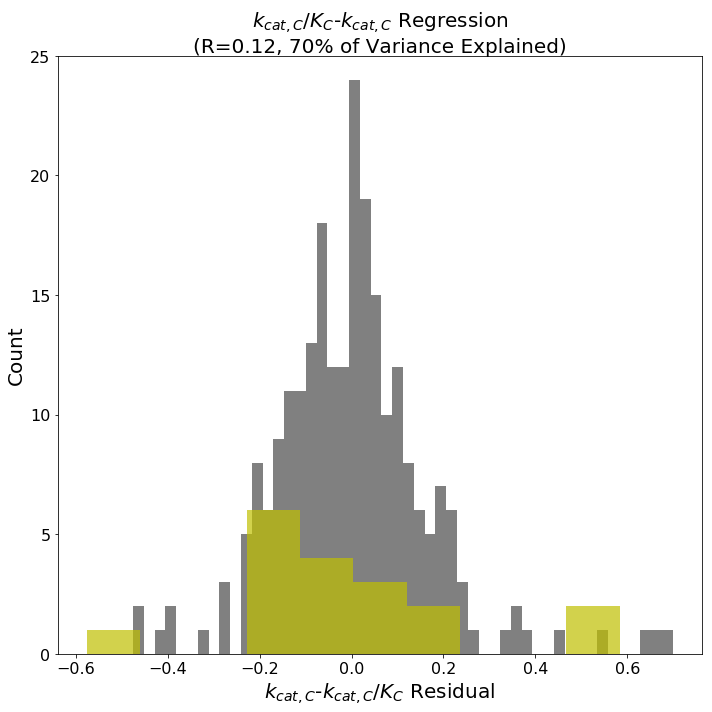

In [6]:
# 2D TLS regression of these variables
vars2use = ['vC', 'kon_C']
v1, v2 = vars2use
xvar_name = '$k_{cat,C}$'
yvar_name = '$k_{cat,C}/K_C$'
xlabel = '%s-%s Residual' % (xvar_name, yvar_name)

# Log10 transform, drop NaN, center on 0.0 for both vars
X_lin = F1_data[vars2use]
X_log = np.log10(X_lin).dropna()
X_log_zeromean = (X_log-X_log.mean(axis=0))
N = X_log_zeromean.shape[0]
print('Total data points:', N)

# Same for Savir et al 2010 data
savir_lin = savir_F1[vars2use]
savir_log = np.log10(savir_lin).dropna()
savir_log_zeromean = (savir_log-savir_log.mean(axis=0))
print('Savir data points:', savir_log.shape[0])

# Covariance matrix calc, SVD
C = (X_log_zeromean.T @ X_log_zeromean)/N
print('Log-scale Covariance Matrix: C = \n', C.round(3))
print('trace(C) = %.3g' % np.trace(C))
U, S, _ = svd(C)

# Singular vals are eigenvalues b/c C is a square symmetric matrix
print('\nEigenvalues of C (decreasing order): ', S.round(3))
print('sum(S) = %.3g' % sum(S))
pct_var = (S[0]/sum(S))*100
pearson_r, pearson_p = pearsonr(X_log[v1], X_log[v2])
print('%% variance explained = %.3g' % pct_var)
print('Pearson R = %.3g, P = %.3g' % (pearson_r, pearson_p))

# Rotate to covariance 0
X_rot = (X_log_zeromean @ U).as_matrix()
savir_rot = (savir_log_zeromean @ U).as_matrix()

sns.color_palette('Set2')

figure = plt.figure(figsize=(10,10))
plt.hist(X_rot[:,1], bins=50, color='0.5',
         label='All data')
plt.hist(savir_rot[:,1], bins=10, color='y', alpha=0.7,
         label='Savir 2010 data')

plt.xlabel(xlabel, fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 25)

title = '%s-%s Regression\n(R=%.2g, %.0f%% of Variance Explained)' % (
    yvar_name, xvar_name, pearson_r, pct_var)
plt.title(title, fontsize=20)
plt.tight_layout()

plt.savefig('figs12/figs12_konc_vs_kcatc.png', dpi=600)

plt.show()

Total data points: 180
Savir data points: 15
Log-scale Covariance Matrix: C = 
        kon_O  kon_C
kon_O  0.058  0.057
kon_C  0.057  0.062
trace(C) = 0.121

Eigenvalues of C (decreasing order):  [0.117 0.003]
sum(S) = 0.121
% variance explained = 97.2
Pearson R = 0.943, P = 5.53e-87


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


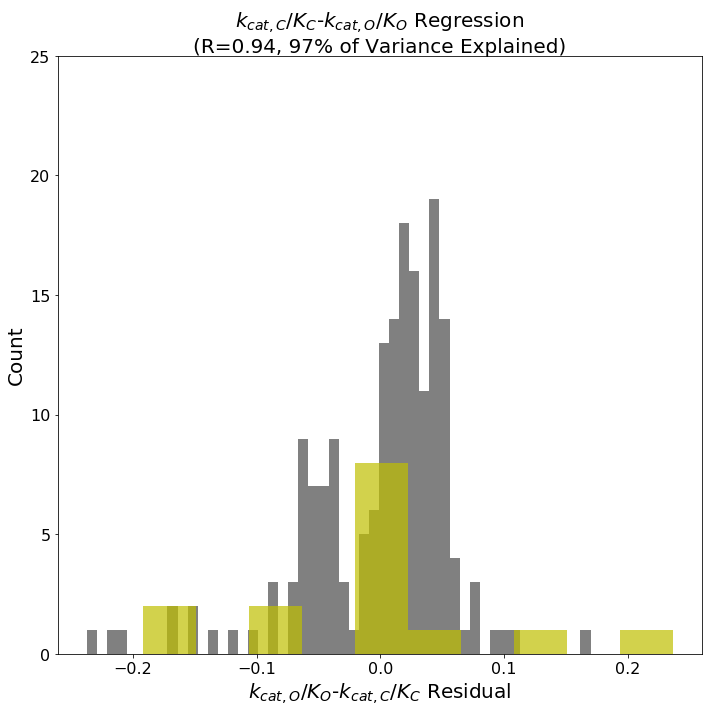

In [7]:
# 2D TLS regression of these variables
vars2use = ['kon_O', 'kon_C']
v1, v2 = vars2use
xvar_name = '$k_{cat,O}/K_O$'
yvar_name = '$k_{cat,C}/K_C$'
xlabel = '%s-%s Residual' % (xvar_name, yvar_name)

# Log10 transform, drop NaN, center on 0.0 for both vars
X_lin = F1_data[vars2use]
X_log = np.log10(X_lin).dropna()
X_log_zeromean = (X_log-X_log.mean(axis=0))
N = X_log_zeromean.shape[0]
print('Total data points:', N)

# Same for Savir et al 2010 data
savir_lin = savir_F1[vars2use]
savir_log = np.log10(savir_lin).dropna()
savir_log_zeromean = (savir_log-savir_log.mean(axis=0))
print('Savir data points:', savir_log.shape[0])

# Covariance matrix calc, SVD
C = (X_log_zeromean.T @ X_log_zeromean)/N
print('Log-scale Covariance Matrix: C = \n', C.round(3))
print('trace(C) = %.3g' % np.trace(C))
U, S, _ = svd(C)

# Singular vals are eigenvalues b/c C is a square symmetric matrix
print('\nEigenvalues of C (decreasing order): ', S.round(3))
print('sum(S) = %.3g' % sum(S))
pct_var = (S[0]/sum(S))*100
pearson_r, pearson_p = pearsonr(X_log[v1], X_log[v2])
print('%% variance explained = %.3g' % pct_var)
print('Pearson R = %.3g, P = %.3g' % (pearson_r, pearson_p))

# Rotate to covariance 0
X_rot = (X_log_zeromean @ U).as_matrix()
savir_rot = (savir_log_zeromean @ U).as_matrix()

sns.color_palette('Set2')

figure = plt.figure(figsize=(10,10))
plt.hist(X_rot[:,1], bins=50, color='0.5',
         label='All data')
plt.hist(savir_rot[:,1], bins=10, color='y', alpha=0.7,
         label='Savir 2010 data')

plt.xlabel(xlabel, fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 25)

title = '%s-%s Regression\n(R=%.2g, %.0f%% of Variance Explained)' % (
    yvar_name, xvar_name, pearson_r, pct_var)
plt.title(title, fontsize=20)
plt.tight_layout()

plt.savefig('figs12/figs12_konc_vs_kono.png', dpi=600)

plt.show()